In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drw-crypto-market-prediction/sample_submission.csv
/kaggle/input/drw-crypto-market-prediction/train.parquet
/kaggle/input/drw-crypto-market-prediction/test.parquet


In [2]:
!pip install koolbox scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 32.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


Imports and configs

In [3]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from scipy.stats import pearsonr as pr
from xgboost import XGBRegressor
from sklearn.base import clone
from koolbox import Trainer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import joblib
import glob
import gc

warnings.filterwarnings("ignore")

In [4]:
class CFG:
    train_path = "/kaggle/input/drw-crypto-market-prediction/train.parquet"
    test_path = "/kaggle/input/drw-crypto-market-prediction/test.parquet"
    sample_sub_path = "/kaggle/input/drw-crypto-market-prediction/sample_submission.csv"

    target = "label"
    n_folds = 5
    seed = 42

    run_optuna = True
    n_optuna_trials = 500

In [5]:
class Params:
    lgbm_params = {
        "boosting_type": "gbdt",
        "colsample_bytree": 0.5625888953382505,
        "learning_rate": 0.029312951475451557,
        "min_child_samples": 63,
        "min_child_weight": 0.11456572852335424,
        "n_estimators": 126,
        "n_jobs": -1,
        "num_leaves": 37,
        "random_state": 42,
        "reg_alpha": 85.2476527854083,
        "reg_lambda": 99.38305361388907,
        "subsample": 0.450669817684892,
        "verbose": -1
    }

    lgbm_goss_params = {
        "boosting_type": "goss",
        "colsample_bytree": 0.34695458228489784,
        "learning_rate": 0.031023014900595287,
        "min_child_samples": 30,
        "min_child_weight": 0.4727729225033618,
        "n_estimators": 220,
        "n_jobs": -1,
        "num_leaves": 58,
        "random_state": 42,
        "reg_alpha": 38.665994901468224,
        "reg_lambda": 92.76991677464294,
        "subsample": 0.4810891284493255,
        "verbose": -1
    }

    xgb_params = {
        "colsample_bylevel": 0.4778015829774066,
        "colsample_bynode": 0.362764358742407,
        "colsample_bytree": 0.7107423488010493,
        "gamma": 1.7094857725240398,
        "learning_rate": 0.02213323588455387,
        "max_depth": 20,
        "max_leaves": 12,
        "min_child_weight": 16,
        "n_estimators": 1667,
        "n_jobs": -1,
        "random_state": 42,
        "reg_alpha": 39.352415706891264,
        "reg_lambda": 75.44843704068275,
        "subsample": 0.06566669853471274,
        "verbosity": 0
    }

Data loading and preprocessing

In [6]:
def reduce_mem_usage(dataframe, dataset):    
    print('Reducing memory usage for:', dataset)
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                dataframe[col] = dataframe[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                dataframe[col] = dataframe[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe

In [7]:
train = pd.read_parquet(CFG.train_path).reset_index(drop=True)
test = pd.read_parquet(CFG.test_path).reset_index(drop=True)

train = reduce_mem_usage(train, "train")
test = reduce_mem_usage(test, "test")

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test.drop(CFG.target, axis=1)

Reducing memory usage for: train
--- Memory usage before: 3594.93 MB
--- Memory usage after: 961.92 MB
--- Decreased memory usage by 73.2%

Reducing memory usage for: test
--- Memory usage before: 3678.76 MB
--- Memory usage after: 984.36 MB
--- Decreased memory usage by 73.2%



In [8]:
features = [
    # https://www.kaggle.com/code/sadettinamilverdil/yat-r-m-tavsiyesi-de-ildir
    "X863", "X856", "X344", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
    "X415", "X345", "X137", "X855", "X174", "X302", "X178", "X532", "X168", "X612",
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume"
]

X = X[features]
X_test = X_test[features]

Training base models

In [9]:
def pearsonr(y_true, y_pred):
    return pr(y_true, y_pred)[0]

In [10]:
fold_scores = {}
overall_scores = {}

oof_preds = {}
test_preds = {}

LightGBM (gbdt)

In [11]:
lgbm_trainer = Trainer(
    LGBMRegressor(**Params.lgbm_params),
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

lgbm_trainer.fit(X, y)

fold_scores["LightGBM (gbdt)"] = lgbm_trainer.fold_scores
overall_scores["LightGBM (gbdt)"] = [pearsonr(lgbm_trainer.oof_preds, y)]
oof_preds["LightGBM (gbdt)"] = lgbm_trainer.oof_preds
test_preds["LightGBM (gbdt)"] = lgbm_trainer.predict(X_test)

Training LGBMRegressor

--- Fold 0 - pearsonr: 0.119944 - Time: 3.96 s
--- Fold 1 - pearsonr: 0.101273 - Time: 3.82 s
--- Fold 2 - pearsonr: 0.023888 - Time: 3.86 s
--- Fold 3 - pearsonr: 0.159401 - Time: 3.87 s
--- Fold 4 - pearsonr: 0.086810 - Time: 3.75 s

------ Overall pearsonr: 0.088687 - Mean pearsonr: 0.098263 ± 0.044452 - Time: 20.02 s


LightGBM (goss)

In [12]:
lgbm_goss_trainer = Trainer(
    LGBMRegressor(**Params.lgbm_goss_params),
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

lgbm_goss_trainer.fit(X, y)

fold_scores["LightGBM (goss)"] = lgbm_goss_trainer.fold_scores
overall_scores["LightGBM (goss)"] = [pearsonr(lgbm_goss_trainer.oof_preds, y)]
oof_preds["LightGBM (goss)"] = lgbm_goss_trainer.oof_preds
test_preds["LightGBM (goss)"] = lgbm_goss_trainer.predict(X_test)

Training LGBMRegressor

--- Fold 0 - pearsonr: 0.125020 - Time: 7.40 s
--- Fold 1 - pearsonr: 0.101415 - Time: 7.36 s
--- Fold 2 - pearsonr: 0.034181 - Time: 7.20 s
--- Fold 3 - pearsonr: 0.156489 - Time: 7.24 s
--- Fold 4 - pearsonr: 0.093788 - Time: 9.01 s

------ Overall pearsonr: 0.096503 - Mean pearsonr: 0.102178 ± 0.040413 - Time: 38.97 s


XGBoost

In [13]:
xgb_trainer = Trainer(
    XGBRegressor(**Params.xgb_params),
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

xgb_trainer.fit(X, y)

fold_scores["XGBoost"] = xgb_trainer.fold_scores
overall_scores["XGBoost"] = [pearsonr(xgb_trainer.oof_preds, y)]
oof_preds["XGBoost"] = xgb_trainer.oof_preds
test_preds["XGBoost"] = xgb_trainer.predict(X_test)

Training XGBRegressor

--- Fold 0 - pearsonr: 0.186980 - Time: 26.34 s
--- Fold 1 - pearsonr: 0.126919 - Time: 27.02 s
--- Fold 2 - pearsonr: 0.085247 - Time: 26.96 s
--- Fold 3 - pearsonr: 0.162445 - Time: 25.82 s
--- Fold 4 - pearsonr: 0.137543 - Time: 24.19 s

------ Overall pearsonr: 0.137687 - Mean pearsonr: 0.139827 ± 0.034310 - Time: 131.10 s


AutoGluon

In [14]:
#oof_preds_files = glob.glob(f'/kaggle/input/drw-crypto-market-prediction-autogluon/*_oof_preds_*.pkl')
#test_preds_files = glob.glob(f'/kaggle/input/drw-crypto-market-prediction-autogluon/*_test_preds_*.pkl')

#ag_oof_preds = joblib.load(oof_preds_files[0])
#ag_test_preds = joblib.load(test_preds_files[0])

#ag_score = [pearsonr(ag_oof_preds, y)]

#ag_scores = []
#split = KFold(n_splits=CFG.n_folds).split(X, y)
#for _, val_idx in split:
 #   y_val = y[val_idx]
  #  y_preds = ag_oof_preds[val_idx]   
   # score = pearsonr(y_preds, y_val)
    #ag_scores.append(score)
    
#oof_preds["AutoGluon"], test_preds["AutoGluon"], overall_scores["AutoGluon"], fold_scores["AutoGluon"] = ag_oof_preds, ag_test_preds, ag_score, ag_scores

Ensembling with Ridge

In [15]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [16]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [17]:
joblib.dump(X, "oof_preds.pkl")
joblib.dump(X_test, "test_preds.pkl")

['test_preds.pkl']

In [18]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 1),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "positive": trial.suggest_categorical("positive", [True, False])
    }

    trainer = Trainer(
        Ridge(**params),
        cv=KFold(n_splits=5, shuffle=False),
        metric=pearsonr,
        task="regression",
        verbose=False
    )
    trainer.fit(X, y)
    
    return pearsonr(trainer.oof_preds, y)

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True, n_startup_trials=CFG.n_optuna_trials // 10)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1, catch=(ValueError,))
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"],
        "fit_intercept": best_params["fit_intercept"],
        "positive": best_params["positive"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-06-23 07:52:15,560] A new study created in memory with name: no-name-f3389a4a-dd81-4654-a8c3-2246d5eff332
[I 2025-06-23 07:52:19,119] Trial 1 finished with value: 0.13369453547450366 and parameters: {'alpha': 0.3100245723322236, 'tol': 0.005731158434749817, 'fit_intercept': True, 'positive': False}. Best is trial 1 with value: 0.13369453547450366.
[I 2025-06-23 07:52:19,658] Trial 2 finished with value: 0.1336943249265802 and parameters: {'alpha': 0.6382909553867678, 'tol': 0.00957922186618767, 'fit_intercept': True, 'positive': False}. Best is trial 1 with value: 0.13369453547450366.
[I 2025-06-23 07:52:19,677] Trial 0 finished with value: 0.13369469522199282 and parameters: {'alpha': 0.060861002915722495, 'tol': 0.005131725347997013, 'fit_intercept': True, 'positive': False}. Best is trial 0 with value: 0.13369469522199282.
[I 2025-06-23 07:52:21,352] Trial 3 finished with value: 0.13005938283777815 and parameters: {'alpha': 0.23994248331669443, 'tol': 0.002561139132476912, '

In [19]:
ridge_trainer = Trainer(
    Ridge(**ridge_params),
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

ridge_trainer.fit(X, y)

fold_scores["Ridge (ensemble)"] = ridge_trainer.fold_scores
overall_scores["Ridge (ensemble)"] = [pearsonr(ridge_trainer.oof_preds, y)]
ridge_test_preds = ridge_trainer.predict(X_test)

Training Ridge

--- Fold 0 - pearsonr: 0.193956 - Time: 0.07 s
--- Fold 1 - pearsonr: 0.125342 - Time: 0.06 s
--- Fold 2 - pearsonr: 0.097022 - Time: 0.06 s
--- Fold 3 - pearsonr: 0.137610 - Time: 0.06 s
--- Fold 4 - pearsonr: 0.143411 - Time: 0.06 s

------ Overall pearsonr: 0.137393 - Mean pearsonr: 0.139468 ± 0.031588 - Time: 1.10 s


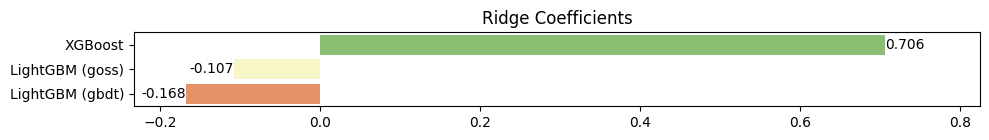

In [20]:
ridge_coeffs = np.zeros((1, X.shape[1]))
for m in ridge_trainer.estimators:
    ridge_coeffs += m.coef_
ridge_coeffs = ridge_coeffs / len(ridge_trainer.estimators)

plot_weights(ridge_coeffs, "Ridge Coefficients")

In [21]:
sub = pd.read_csv(CFG.sample_sub_path)
sub["prediction"] = ridge_test_preds
sub.to_csv(f"sub_ridge_{overall_scores['Ridge (ensemble)'][0]:.6f}.csv", index=False)
sub.head()

,ID,prediction
0,1,0.116717
1,2,-0.070377
2,3,0.138507
3,4,-0.074759
4,5,0.144158
